In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings
import numpy as np
import prophet
from prophet.diagnostics import cross_validation
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from IPython import display
import io
import sys
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:48 - cmdstanpy - INFO - Chain [1] start processing
21:01:48 - cmdstanpy - INFO - Chain [1] done processing
21:01:48 - cmdstanpy - INFO - Chain [1] start processing
21:01:48 - cmdstanpy - INFO - Chain [1]

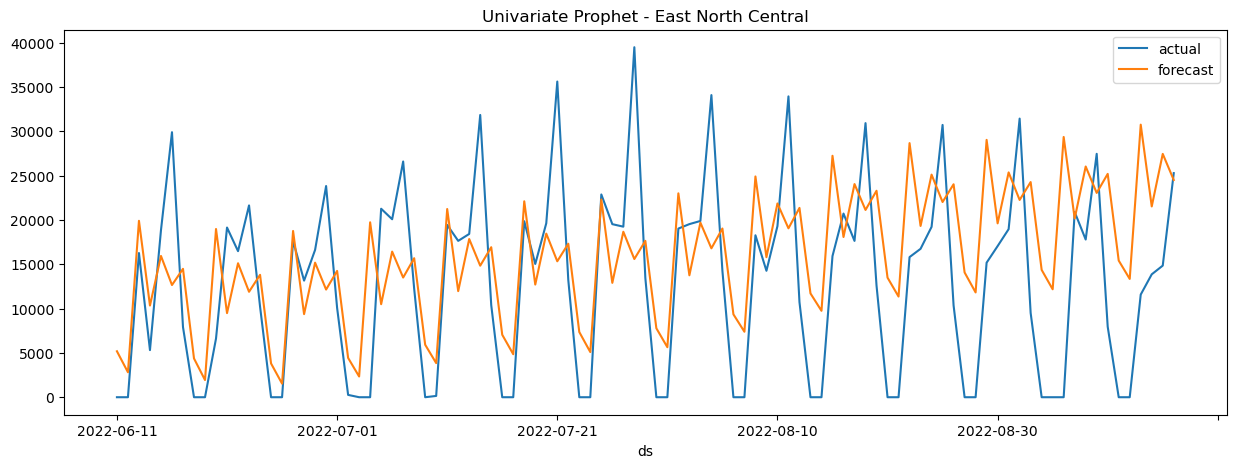

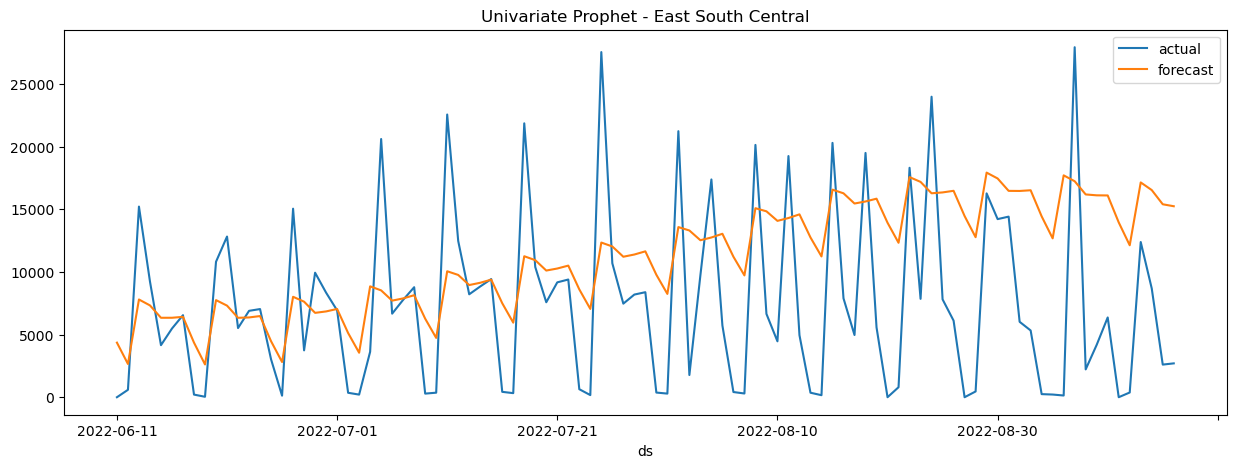

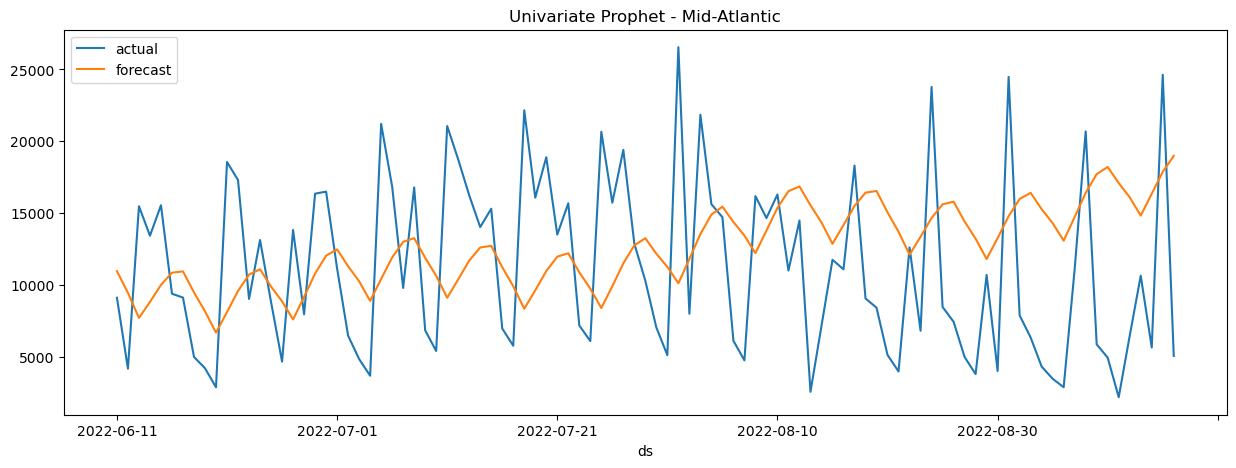

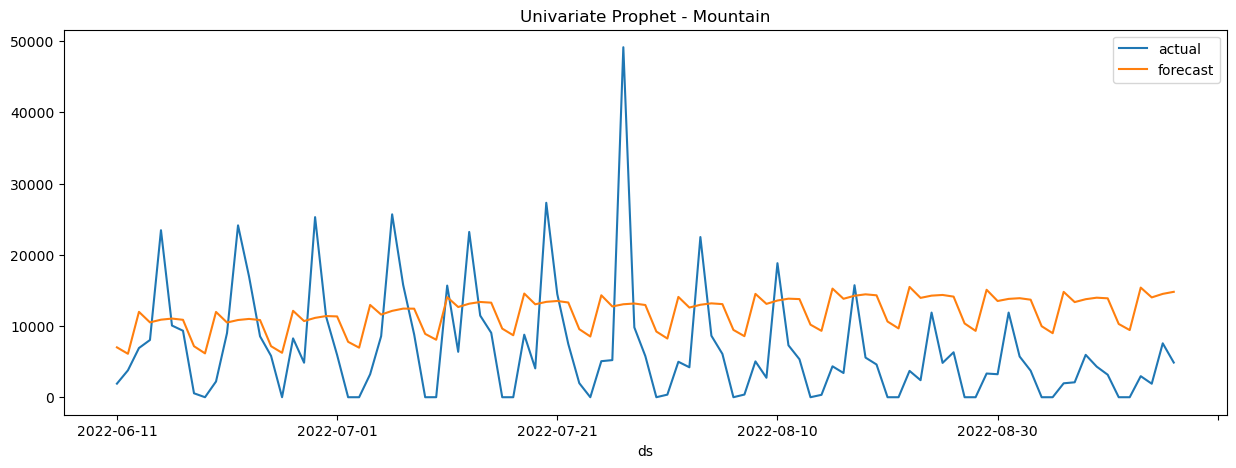

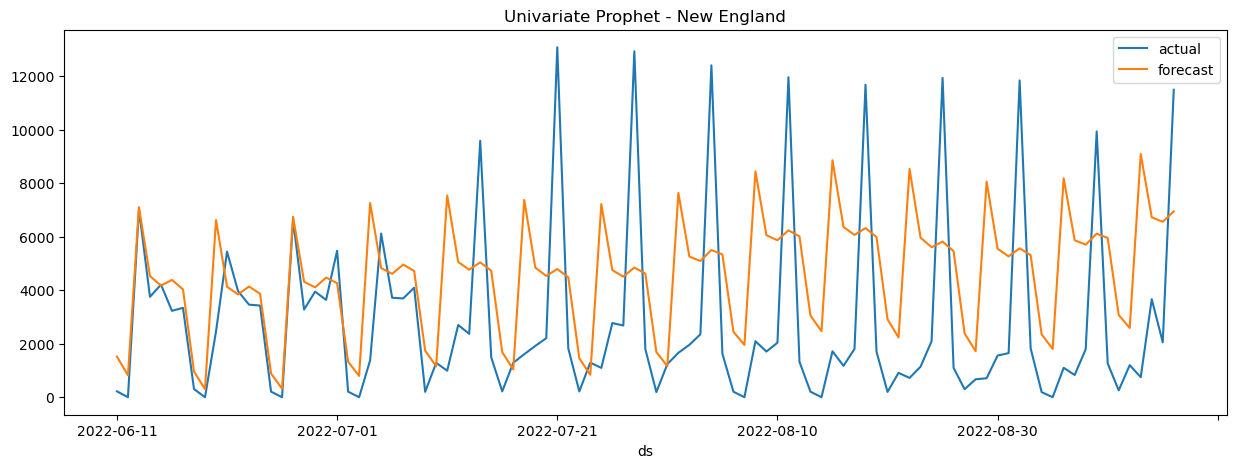

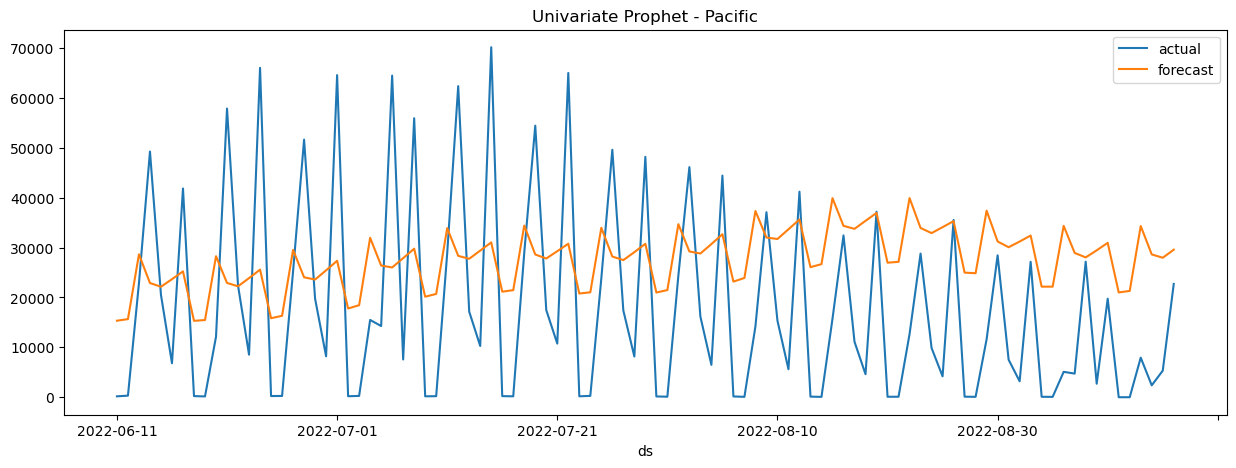

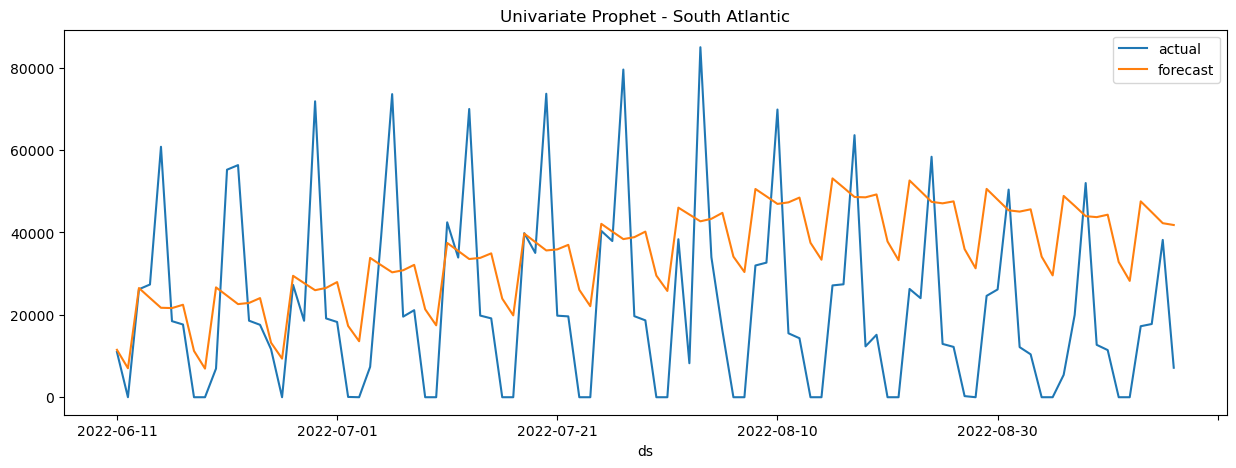

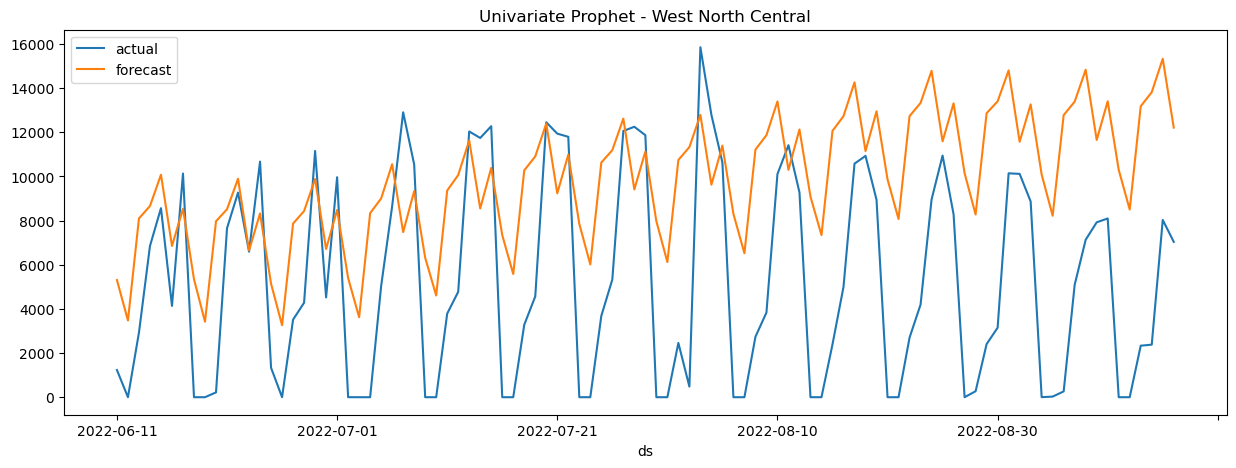

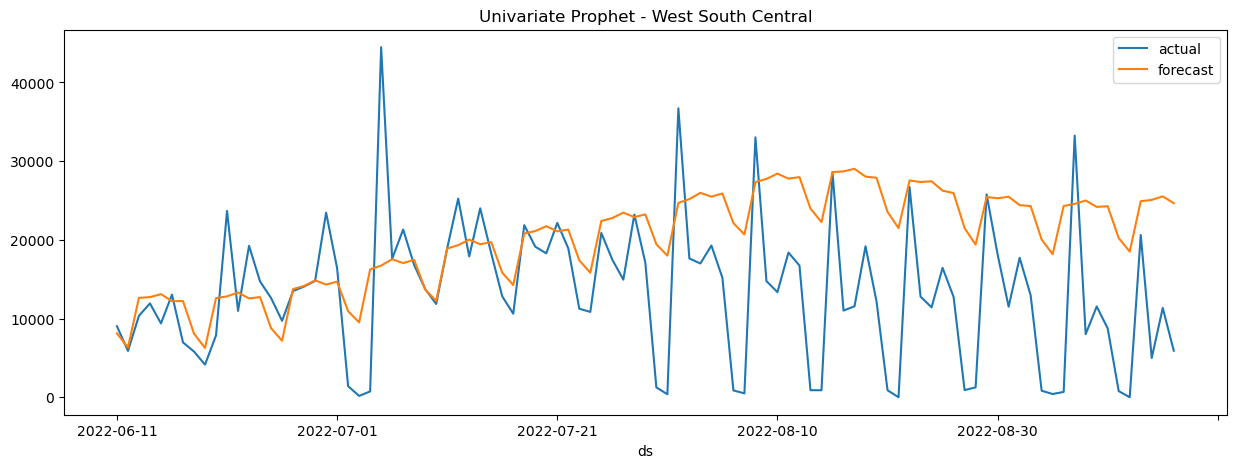

In [58]:
import random
params_grid = {'changepoint_prior_scale':[0.001, 0.005,0.01, 0.05, 0.1, 0.5],
              'seasonality_prior_scale':[0.1,0.5,1,2,3,5,10]}
grid = ParameterGrid(params_grid)
best_params = []
best_mases = []
best_maes = []
best_rmses = []
regions = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    data = data1[['date', 'new_confirmed']].rename(columns = {'date': 'ds', 'new_confirmed': 'y'})
    size = round(data.shape[0]*0.1)
    train = data.iloc[:-size*2]
    val = data.iloc[-size*2:-size]
    trainval = data.iloc[:-size]
    test = data.iloc[-size:].reset_index().drop(columns = 'index')
    params = []
    smapes = []
    mases = []
    for p in grid:
        params.append(p)
        random.seed(0)
        train_model = prophet.Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                                    seasonality_prior_scale=p['seasonality_prior_scale'])
        train_model.add_country_holidays(country_name='US')
        train_model = train_model.fit(train)
        # val_pred = cross_validation(train_model, initial='400 days', period='90 days', horizon = '180 days')
        val_pred = train_model.predict(val)
        smapetemp = smape(val.y, val_pred.yhat)
        smapes.append(smapetemp)
        masetemp = mean_absolute_scaled_error(val.y, val_pred.yhat, y_train = train.y)
        mases.append(masetemp)
    p = params[np.argmin(mases)]
    best_params.append(p)
    print(p)
    model = prophet.Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                            seasonality_prior_scale=p['seasonality_prior_scale'])
    model.add_country_holidays(country_name = 'US')
    model = model.fit(trainval)
    test_pred = model.predict(test)
    # test = test.set_index('ds')
    # plt.figure(figsize = (15,5))
#     pd.concat([pd.concat([ytrain, ytest]).reset_index().new_confirmed, 
#            pd.DataFrame(np.concatenate((train_pred, test_pred)))[0]], axis = 1).plot(figsize = (15,5))
    pd.DataFrame({'New Cases': test.y, 'Predicted New Cases': test_pred.yhat}).set_index(test.ds).plot(figsize = (15,5))
    plt.legend(['actual', 'forecast'])
#     plt.axvline(x = len(ytrain), color = 'green')
    plt.title('Univariate Prophet - ' + data1.region.unique()[0])
    print(data1.region.unique()[0])
    regions.append(data1.region.unique()[0])
    print('MASE: ', mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y))
    best_mases.append(mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y))
    print('RMSE: ', mean_squared_error(test.y, test_pred.yhat, squared = False))
    best_rmses.append(mean_squared_error(test.y, test_pred.yhat, squared = False))
    print('MAE: ', mean_absolute_error(test.y, test_pred.yhat))
    best_maes.append(mean_absolute_error(test.y, test_pred.yhat))
best_mases = pd.DataFrame({'MASE': best_mases})
best_rmses = pd.DataFrame({'RMSE': best_rmses})
best_maes = pd.DataFrame({'MAE': best_maes})
# best_mases.to_csv('bestmases.csv')
# best_rmses.to_csv('bestrmses.csv')
# best_maes.to_csv('bestmaes.csv')